# This program is to plot the location and field radius of each GC for our study

## Notes for this program

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

# music
import simpleaudio as sa

# time
import time

# save and load
import pickle

# optimization
from scipy.optimize import minimize

# plot text adjusting
import mplcursors

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [2]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt2 = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')


### drop all NaN kinematic and chemistry values
apogee_nofilt = apogee_nofilt2.dropna(subset=['FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'VHELIO_AVG', 'VERR'])
apogee_nofilt = apogee_nofilt.reset_index(drop=True)
GC_db = pd.read_csv('data/GCs_20RHMRT.csv', delimiter=',')

#### Initial star selection

In [3]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df, name, rhm_deg, rt_deg):
    
    fov_new = 5 * rt_deg
    
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov_new and i <= ra + fov_new and df['DEC'].values[count] >= dec - fov_new and df['DEC'].values[count] <= dec + fov_new:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a ' + str(fov_new) + 'x' + str(fov_new) + ' fov of the GC')
    
    '''if len(stars) != 0:
        # create a folder with name of GC only if there are stars in the field
        try: 
            os.makedirs('GCs_10RHM/' + name)
        except OSError as error:
            print('Directory ' + name+ ' already exists')

    ra_arr = np.empty(len(stars), dtype=float)
    dec_arr = np.empty(len(stars), dtype=float)
    for count, i in enumerate(stars):
        ra_arr[count] = i['RA']
        dec_arr[count] = i['DEC']
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm')
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_arr, dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre')
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title(name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    try:
        plt.savefig('GCs_10RHM/'+name+'/radec.png')
    except:
        print('No stars yo')
    plt.close('all')'''
    
    return stars
            

#### Separating list of stars into lists by parameter

In [4]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [5]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [6]:
def master_load(ra, dec, fov, dataset, params, name, rhm_deg, rt_deg):
    stars_found = find_cluster_stars(ra, dec, fov, dataset, name, rhm_deg, rt_deg)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [7]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    #print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [8]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    #print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [9]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    #print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    #print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        #print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        #print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [10]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    #print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    return data_snrfilter

#### Master filter function

In [11]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 15)
    M3_duplicates_filter = dup_filter(M3_abundance_filter)
    M3_SNR_filter = SNR_filter(M3_duplicates_filter)
    
    #print('\nThe final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [12]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg, name):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trhmrt2: {:.2f}\trt: {:.2f}'.format(rhm_deg, (rhm_deg + rt_deg) / 2, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    control_size = min((rhm_deg + rt_deg) / 2, rt_deg)
    
    # Select stars within halfway between r,hm and rt (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, control_size, ra_filtered, dec_filtered)  
    indices_control = np.where(in_halfmass==True)
    
    ### TEST: rhm stars
    in_halfmass2 = in_circle(ra, dec, rhm_deg, ra_filtered, dec_filtered)  
    indices_control2 = np.where(in_halfmass2==True)
    
    # check for stars within rt
    in_rt = in_circle(ra, dec, rt_deg, ra_filtered, dec_filtered)
    indices_control_rt = np.where(in_rt == True)
    
    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)


    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars within rhm".format(len(indices_control2[0])) + " and {} stars within (rhm+rt)/2".format(len(ra_control)) + ' and {} stars within the rt'.format(len(indices_control_rt[0])))
    
    # checking for any control stars within rhm
    if len(indices_control[0]) >= 20:
        # create a folder with name of GC only if there are stars in the rhm
        try: 
            os.makedirs('GCs_20RHMRT_N_ctrl_sigma_cluster/' + name)
        except OSError as error:
            print('Directory ' + name + ' already exists')
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm', zorder=2)
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt', zorder=2)
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt', zorder=2)
    
    fov = 5
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_filtered, dec_filtered, 'ok', linestyle='none', markersize=1, label='Stars', zorder=0.5)
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre', zorder=0.7)
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title('Filtered RA DEC for ' + name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    if len(indices_control[0]) >= 20:
        plt.savefig('GCs_20RHMRT_N_ctrl_sigma_cluster/'+name+'/radec.png')
    plt.close('all')
    
    
    # no control stars within rt
    if len(indices_control[0]) < 20:
        print('Less than 20 control stars within (rhm+rt)/2')
        return [None]
    
    else:
        return indices_control

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [13]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pre_nonerr_array = []
    params_arr = []
    
    pre_err_array = []
    
    print(data_filter)
    
    for key in param_dict:
        if 'err' not in str(key):
            pre_nonerr_array.append(data_filter[param_dict[key]])
            params_arr.append(key)
        else:
            pre_err_array.append(data_filter[param_dict[key]])
    
    pre_nonerr_array = np.array(pre_nonerr_array)
    pre_err_array = np.array(pre_err_array)
    
    standardized = []
    standardized_err = []
    
    for i in pre_nonerr_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized.append(i)
        
    for i in pre_err_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized_err.append(i)
        
    return [standardized, standardized_err]

#### Taking in datasheet and name and automatically getting the parameters

In [14]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [16]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

#### Global GC params

In [17]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR', 'ASPCAPFLAG', 'STARFLAG',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']
abundance_index = 15 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                  'FE_H_err': abundance_index + 1,
                  'C_FE': abundance_index + 2,
                  'C_FE_err': abundance_index + 3,
                  'CI_FE': abundance_index + 4,
                  'CI_FE_err': abundance_index + 5,
                  'N_FE': abundance_index + 6,
                  'N_FE_err': abundance_index + 7,
                  'O_FE': abundance_index + 8,
                  'O_FE_err': abundance_index + 9,
                  'MG_FE': abundance_index + 10,
                  'MG_FE_err': abundance_index + 11,
                  'AL_FE': abundance_index + 12,
                  'AL_FE_err': abundance_index + 13,
                  'SI_FE': abundance_index + 14,
                  'SI_FE_err': abundance_index + 15,
                  'P_FE': abundance_index + 16,
                  'P_FE_err': abundance_index + 17,
                  'S_FE': abundance_index + 18,
                  'S_FE_err': abundance_index + 19,
                  'K_FE': abundance_index + 20,
                  'K_FE_err': abundance_index + 21,
                  'CA_FE': abundance_index + 22,
                  'CA_FE_err': abundance_index + 23,
                  'TI_FE': abundance_index + 24,
                  'TI_FE_err': abundance_index + 25,
                  'TIII_FE': abundance_index + 26,
                  'TIII_FE_err': abundance_index + 27,
                  'V_FE': abundance_index + 28,
                  'V_FE_err': abundance_index + 29,
                  'CR_FE': abundance_index + 30,
                  'CR_FE_err': abundance_index + 31,
                  'MN_FE': abundance_index + 32,
                  'MN_FE_err': abundance_index + 33,
                  'CO_FE': abundance_index + 34,
                  'CO_FE_err': abundance_index + 35,
                  'NI_FE': abundance_index + 36,
                  'NI_FE_err': abundance_index + 37,
                  'RV': RV_index, 'RV_err': RV_index + 1,
                  'PMRA': PMRA_index, 'PMRA_err': PMRA_index + 1,
                  'PMDEC': PMDEC_index, 'PMDEC_err': PMDEC_index + 1}

fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

# dim reduction kin

In [49]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

apogee_ra = apogee_nofilt.loc[:, 'RA']
apogee_dec = apogee_nofilt.loc[:, 'DEC']

In [29]:
def get_rt(GC_name, db):
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    return [rhm_deg, rt_deg]

In [30]:
GC_5rt_list = []
GC_rhmrt_list = []

for i in GC_name_list:
    rhm = get_rt(i, GC_db)[0]
    rt = get_rt(i, GC_db)[1]
    
    GC_5rt_list.append(5 * rt)
    GC_rhmrt_list.append((rhm + rt) / 2)

<ipython-input-97-be9460f937be>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 361, 30), fontsize=40)
<ipython-input-97-be9460f937be>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(-90, 91, 15), fontsize=40)


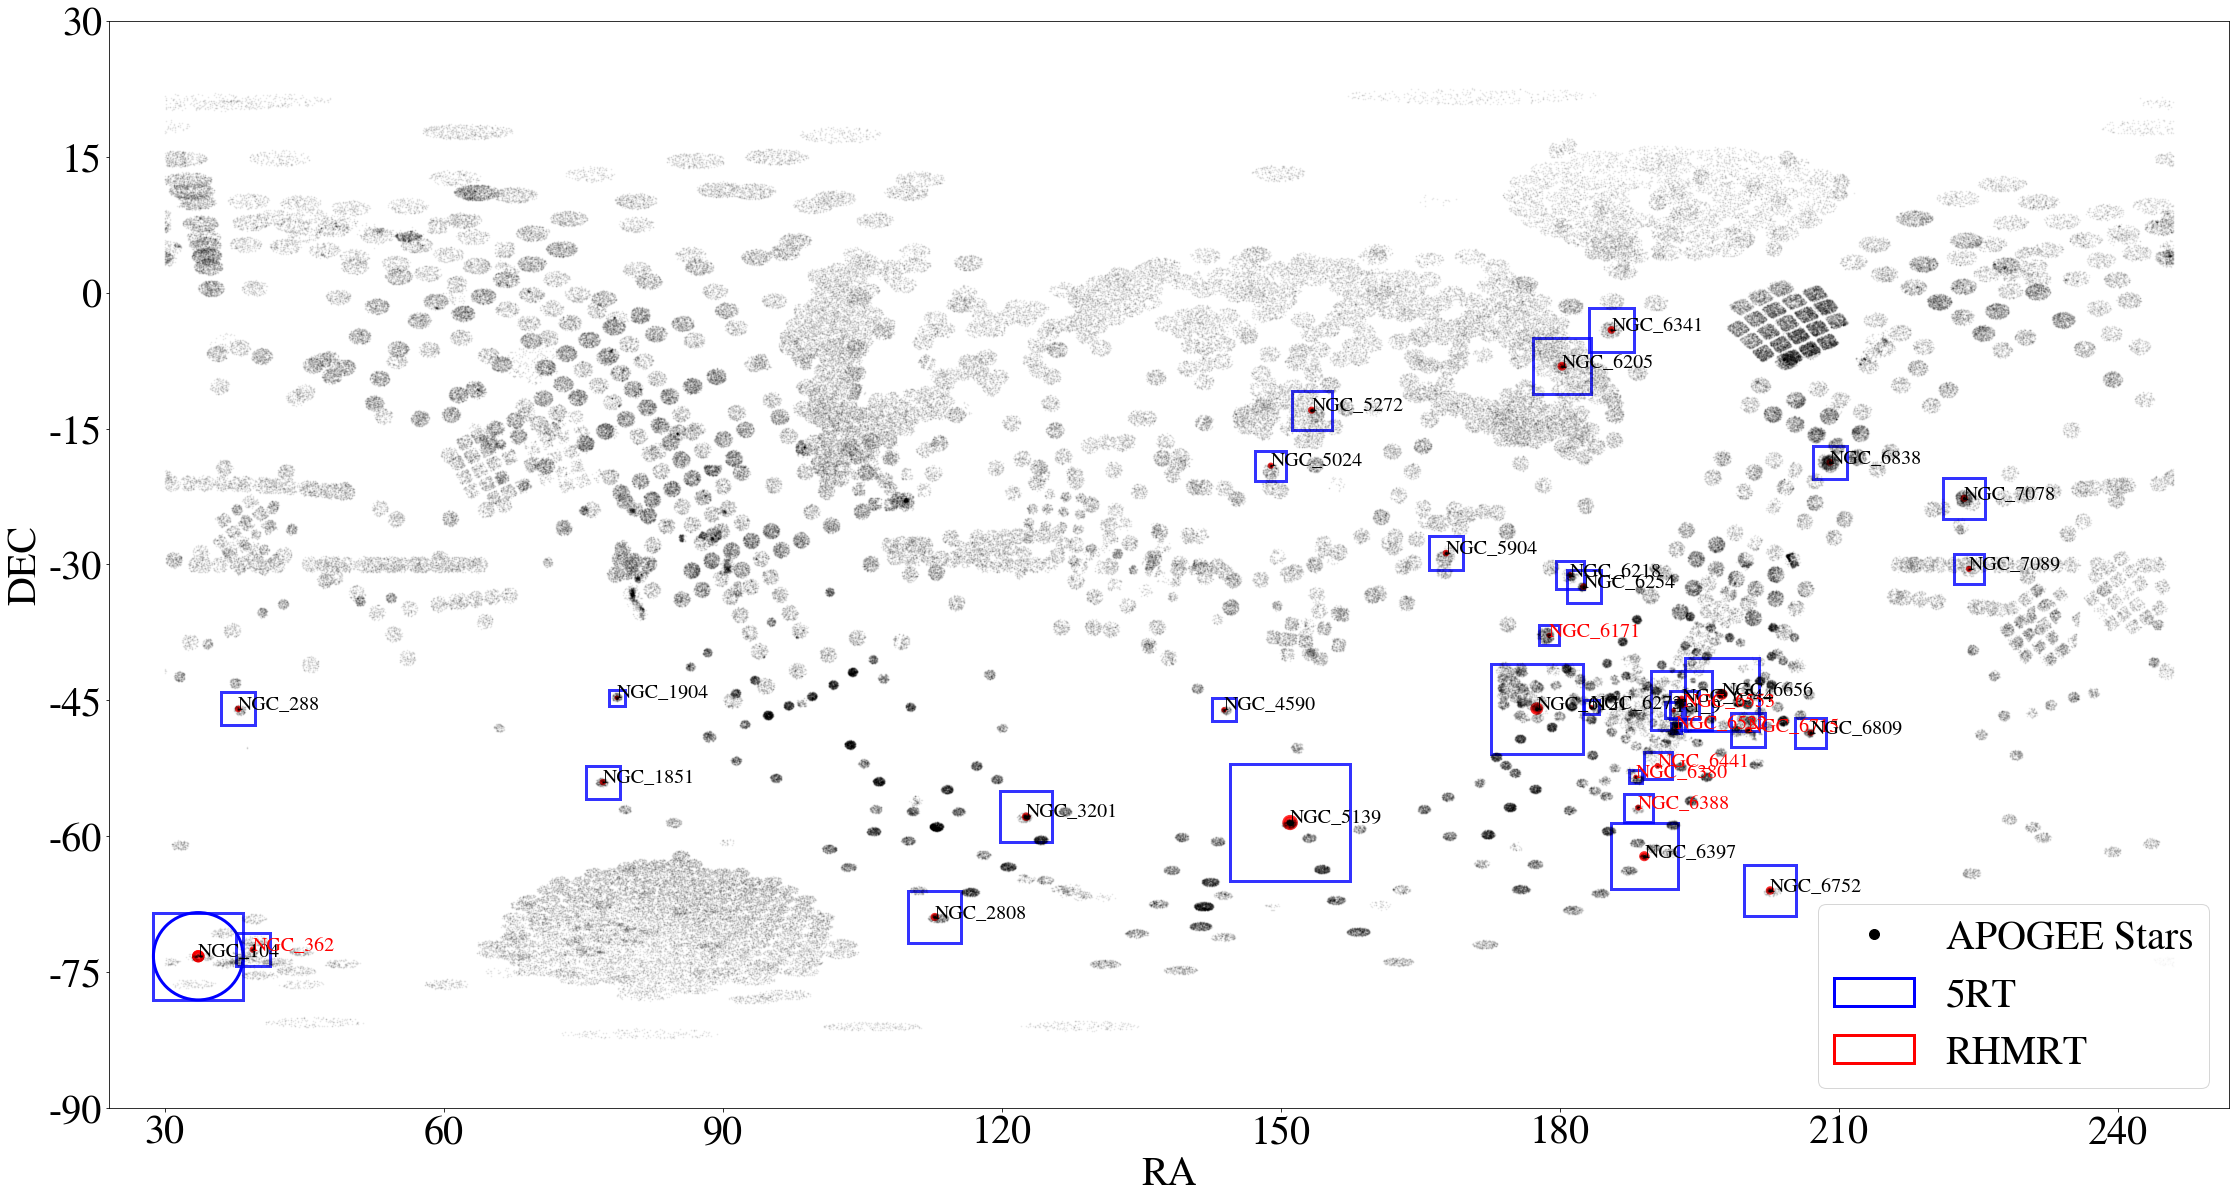

In [97]:
bad_GCs = ['NGC_362', 'NGC_6171', 'NGC_6380', 'NGC_6388', 'NGC_6441', 'Ter9', 'NGC_6522', 'NGC_6553', 'NGC_6715']

fig, ax = plt.subplots(1, figsize=(38, 20))
for i in range(len(GC_5rt_list)):
    rt_rect = plt.Rectangle((GC_ra_list[i] - GC_5rt_list[i], GC_dec_list[i] - GC_5rt_list[i]), 2 * GC_5rt_list[i], 2 * GC_5rt_list[i], color='b', alpha=0.8, linestyle='-', linewidth=3, fill=False)
    rhmrt_circ = plt.Circle((GC_ra_list[i], GC_dec_list[i]), GC_rhmrt_list[i], color='r', alpha=0.8, linestyle='-', linewidth=3, fill=True)
    ax.add_patch(rt_rect)
    ax.add_patch(rhmrt_circ)
    
    if GC_name_list[i] in bad_GCs:
        c = 'r'
    else:
        c = 'k'
        
    ax.annotate(GC_name_list[i], (GC_ra_list[i], GC_dec_list[i]), color=c, fontsize=20)

ax.plot(-1000, -1000, 'ok', alpha=1, linestyle='none', markersize=10, label='APOGEE Stars')
ax.plot(apogee_ra, apogee_dec, 'ok', alpha=0.05, linestyle='none', markersize=1, rasterized=True)
    
rt_circ = plt.Circle((GC_ra_list[0], GC_dec_list[0]), GC_5rt_list[0], color='b', linestyle='-', linewidth=3, fill=False, label='5RT')
rhmrt_circ = plt.Circle((GC_ra_list[0], GC_dec_list[0]), GC_rhmrt_list[0], color='r', linestyle='-', linewidth=3, fill=False, label='RHMRT')
ax.add_patch(rt_circ)
ax.add_patch(rhmrt_circ)

#ax.plot(GC_ra_list, GC_dec_list, color='magenta', markersize=5, linestyle='none')

ax.set_xticklabels(np.arange(0, 361, 30), fontsize=40)
ax.set_yticklabels(np.arange(-90, 91, 15), fontsize=40)
#ax.set_title('RA DEC plot of all 34 GCs in the study\nControl star selection radius: Red\nField star selection box: Blue\nRed GCs means no control stars found', fontsize=40)
ax.set_xlabel('RA', fontsize=40)
ax.set_ylabel('DEC', fontsize=40)
ax.set_ylim(-100, 100)
ax.set_xlim(-10, 370)
ax.legend(fontsize=40)
plt.savefig('apogee_GCs.png', dpi=200)
plt.show()